# Обучение моделей
В этом файле представлено обучение моделей по обработанным в предыдущем файле данным

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

Сначала считаем **тренировочный** датафрейм из закодированного файла

In [131]:
train_df = pd.read_csv('train_transform.csv')
train_df.set_index('Id', inplace=True)
train_df.head(3)

,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,193562.333333,172579.094556,169601.131997,197411.994318,7,5,2003,...,0,0,0,1,0,0,0,1,0,1
2,20,80.0,9600,213055.555556,141297.955882,169601.131997,164390.432079,6,8,1976,...,0,0,0,1,0,0,0,1,0,1
3,60,68.0,11250,193562.333333,172579.094556,169601.131997,197411.994318,7,5,2001,...,0,0,0,1,0,0,0,1,0,1


# Градиентный спуск

Реализуем **численно** метод **градиентного спуска** для **одной вещественной переменной**, например - **LotFrontage**. Напишем 2 вспомогательные функции - **predict** (реализует наш алгоритм А) и **calculate_mse** (вычисляет среднеквадратичную ошибку)

In [134]:
def predict(x, w):
    w0 = w[0]
    w1 = w[1]
    return w0 + x * w1
def calculate_mse(predictions, actuals):
    errors = predictions - actuals
    return np.mean(errors ** 2)

Далее возьмем 2 векторa. `1` - вещественная колонка **LotFrontage**, `2` - вектор ответов **SalePrice**. Превратим их в массивы **numpy**, так же как и наши веса **W** - их начальные значения равны 0. Так же $\lambda_k$ - так называется по определению, в машинном обучении - **`learning rate`**, равное **0.000001** (если брать меньше - есть вероятность что модель будет слишком медленно обучаться и нам понадобится больше данных, если взять слишком большим - у нас произойдет переполнение и наши веса станут **`NaN'ами`**. Пусть количество итераций равно длине массива **x1_array**

In [136]:
x1_array = np.array(train_df['LotFrontage'])
answers = np.array(train_df['SalePrice'])
w = np.array([0.0, 0.0])
learning_rate = 0.000001
N_itarations = len(x1_array)
mse_history = []

Далее запускаем цикл. И с помощью **градиентов** изменяем наш вектор **W**, после чего выведем **конечные веса** и сравним, чему равна цена на самом деле и как эта цена была бы **предсказана** с помощью нашей модели

In [138]:
for i in tqdm(range(N_itarations)):
    predictions = predict(x1_array, w)
    errors = predictions - answers
    now_mse = np.mean(errors ** 2)
    mse_history.append(now_mse)
    
    grad_wo = 2/N_itarations * np.sum(errors)
    grad_w1 = 2/N_itarations * np.sum(errors * x1_array)

    w[0] = w[0] - learning_rate * grad_wo
    w[1] = w[1] - learning_rate * grad_w1     

100%|████████████████████████████████████| 1206/1206 [00:00<00:00, 45499.22it/s]


Конечные веса: [  47.65945148 2394.6083117 ]
Реальная цена = 208500.0
Цена, если бы она была предсказана моделью: 155697.2
График распределения точек вокруг прямой


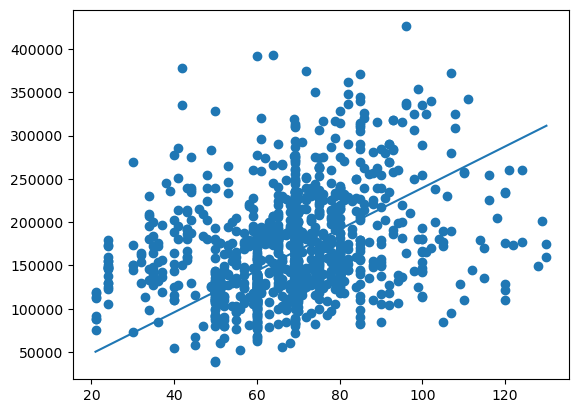

In [139]:
print(f'Конечные веса: {w}')
print(f'Реальная цена = {answers[0]}')
print(f'Цена, если бы она была предсказана моделью: {np.round(w[0] + w[1] * x1_array[0], 2)}')
print('График распределения точек вокруг прямой')
plt.scatter(x1_array, answers)
x0 = min(x1_array)
x1 = max(x1_array)
y1 = w[0] + x0 * w[1]
y2 = w[0] + x1 * w[1]
plt.plot([x0, x1], [y1, y2]);

Как мы можем увидеть есть **значимые** различия. Что ж, это происходит, потому что у нас **слишком маленький вектор весов W**, так как мы используем всего один вещественный признак

Если мы будем использовать все признаки (а их, по факту, **108**) - тогда мы получим более точный результат. В дальнейшем реализуем это через библиотеку **sklearn**, как только будет такая возможность

Так же нарисуем график, чтоы убедиться, что **MSE - уменьшается** с каждой итерацией

Text(0.5, 1.0, 'Изменение MSE в зависимости от итерации в методе градиентного спуска')

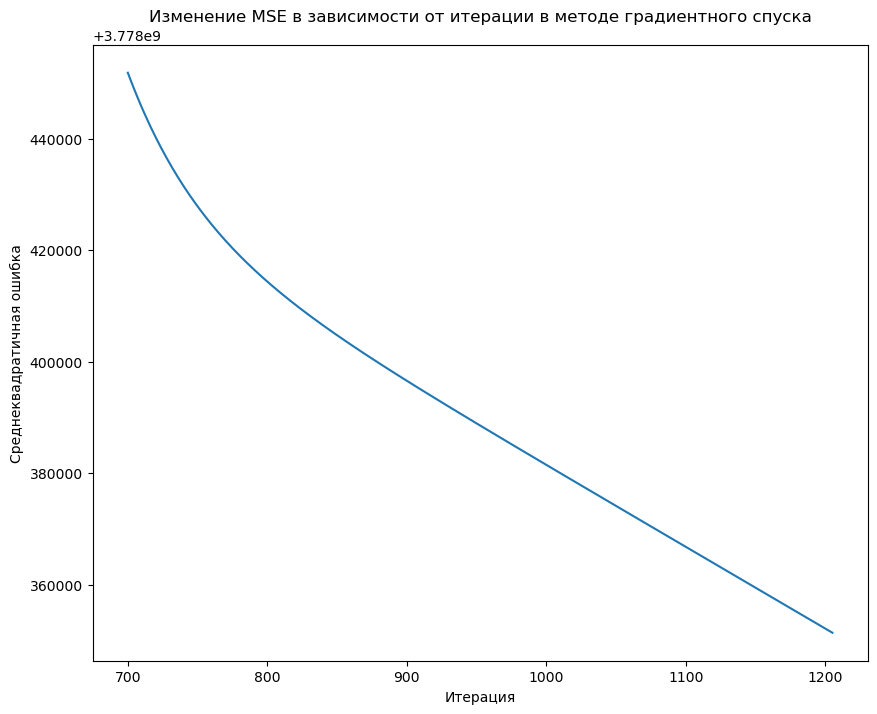

In [141]:
plt.figure(figsize=(10, 8))
plt.plot(range(700, N_itarations), mse_history[700:])
plt.xlabel('Итерация')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('Изменение MSE в зависимости от итерации в методе градиентного спуска')

# Аналитическое решение линейной регрессии

Будет представлен **метод аналитического решения задачи линейной регрессии**. Мы обучим нашу модель на тренировочном датафрейме - `train_df` и протестируем на тестовом - `test_df`.

Пусть вектор **X** - это матрица объектов, то есть все наши признаки, а **Y** - это уже вектор ответов, с помощью которого будем обучать нашу модель

Так же считаем **тестовый датафрейм** в самом начале, чтобы в последующих шагах использовать его

In [144]:
test_df = pd.read_csv('test_transform.csv')
test_df.set_index('Id', inplace=True)
test_df.head(3)

,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,139804.965000,141297.955882,169601.131997,164390.432079,5,6,1961,...,0,0,0,1,0,0,0,1,0,1
1462,20,81.0,14267,139804.965000,172579.094556,169601.131997,164390.432079,6,6,1958,...,0,0,0,1,0,0,0,1,0,1
1463,60,74.0,13830,191165.929577,172579.094556,169601.131997,197411.994318,5,5,1997,...,0,0,0,1,0,0,0,1,0,1


In [145]:
X = train_df.drop('SalePrice', axis=1)
Y = train_df['SalePrice']

Мы можем вычислить **вектор весов W** при помощи формулы: 
$$
    {W = (X^T X)^{-1} X^T Y}
$$
Преобразуем наши выборки в массив numpy, `X_train` - матрица объектов, `Y_train` - вектор ответов, `X_test` - матрица объектов, по которой мы будем предсказывать цену

In [147]:
X_train = np.array(X)
Y_train = np.array(Y)
X_test = np.array(test_df.drop('SalePrice', axis=1))

Теперь добавим колонку с еденицами в `X_train` и в `X_test`. Это мы делаем для того, чтобы мы могли найти свободный член $w_0$ 

Так же выведем **размер** наших матриц и вектора `Y_train`

In [149]:
X_train_one = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_one = np.c_[np.ones((X_test.shape[0], 1)), X_test]
print(f'Size of X_train with added column: {X_train_one.shape}')
print(f'Size of Y_train: {Y_train.shape[0]}')
print(f'Size of X_test with added column: {X_test_one.shape}')

Size of X_train with added column: (1206, 109)
Size of Y_train: 1206
Size of X_test with added column: (1194, 109)


Далее по нашей формуле считаем произведение матриц, транспонируем их, находим обратную матрицу и т.д. 

**Пояснения:**

`@` - знак **умножения** матриц

`X.T` - **транспонирование** матрицы

`numpy.linalg.pinv(X)` - нахождение **обратной** матрицы

Ну и выводим первые элементы **весов W**

In [151]:
XTX = X_train_one.T @ X_train_one
XTX_minus_one = np.linalg.pinv(XTX)
XTY = X_train_one.T @ Y_train
W = XTX_minus_one @ XTY

print('Расчет весов проведен успешно, далее будет аналитика вектора весов:')
print(f'Size of vector W: {W.shape[0]}')
print(f"The first value in W'values: {W[0]}")
print(f'The elements from the 1st to 5th in vector W: {W[1:6]}')

Расчет весов проведен успешно, далее будет аналитика вектора весов:
Size of vector W: 109
The first value in W'values: -630.8070792466071
The elements from the 1st to 5th in vector W: [-119.28487573   14.87070769    0.44523729    0.21235993    0.27391338]


Далее будем находить `Y_prediction_test` - **вектор предсказаний** по тестовым данным

In [153]:
Y_prediction_test = X_test_one @ W
print('The 6th predictions for test sample:')
print(f'{Y_prediction_test[0:6]}')

The 6th predictions for test sample:
[120451.03810967 167250.7669399  186285.35726025 199845.51318746
 194913.06026345 172534.78297986]


Далее посмотрим как работает **наша модель**.

Умножим **тренировочную** матрицу - `X_train_one` - на вектор **весов W**

Выведем **предсказанную цену и реальную ценy**

In [155]:
Y_prediction_train = X_train_one @ W
print('The 6th predictions for train sample:')
print(*np.round(Y_prediction_train[0:6], 1))
print('The 6th real prices for train sample:')
print(*Y_train[0:6])

The 6th predictions for train sample:
208628.6 195220.1 214012.9 274223.8 165651.3 274012.7
The 6th real prices for train sample:
208500.0 181500.0 223500.0 250000.0 143000.0 307000.0


Можем увидеть, что предсказанные цены не так сильно **отличаются** от реальных.

Чтобы убедиться, что у нас разница не велика построим график - `scatterplot`. По оси Х будут **реальные значения**, по оси У - **предсказанные**, ну и посмотрим на получившееся распределение

Text(0.5, 1.0, 'Реальные значения VS Предсказанные значения')

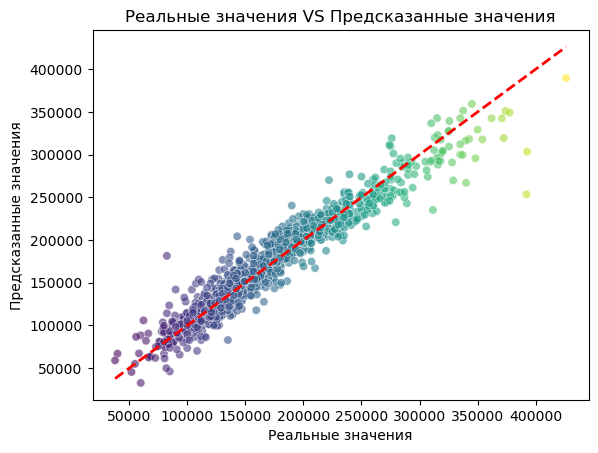

In [157]:
sns.scatterplot(x=Y_train, y=Y_prediction_train, alpha=0.6, palette='viridis', hue=Y_train, legend=False)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения VS Предсказанные значения')

Можем увидеть, что точки **распределены линейно**, есть **пара визуальных выбросов**, поэтому модель работает ***довольно хорошо***

# Метрики для оценки качества модели
К сожалению, в **тестовой выборке** у нас **нет** реальной цены, чтобы посмотреть как работает наша модель на **тестовых данных** (это нам дало бы более **объективную** картину). Поэтому будем все делать на **тренировочной выборке**.

Лучше всего использовать **2 метрики** (по тем данным что я нашел):

1. `MAE` - **средняя абсолютная ошибка**. Показывает, насколько в среднем модель ошибается, игнорируя направление ошибки (завышение или занижение). Измеряется в тех же единицах, что и целевая переменная
$$
    {MAE = (1/N) * Σ |yᵢ - ŷᵢ|}
$$
2. $R^2$ `(R-Squared)` - **коэффициент детерминации**. Показывает, какую долю дисперсии (разброса) целевой переменной Y объясняет ваша модель.
$$
    {R² = 1 - ( Σ(yᵢ - ŷᵢ)² / Σ(yᵢ - ȳ)² )}
$$

Теперь вычислим `среднюю абсолютную ошибку (MAE)` на тренировочной выборке

In [162]:
MAE = 0
length = len(Y_prediction_train)
for prediction, real in tqdm(zip(Y_prediction_train, Y_train)):
    MAE += np.abs(prediction - real)
MAE = MAE / length
MAE

1206it [00:00, 867638.19it/s]


12039.193973425328

Теперь мы посчитаем **среднюю реальную цену** нашей выборки, чтобы сделать какие-то выводы

In [164]:
np.mean(train_df['SalePrice'])

169193.16749585405

In [165]:
MAE / np.mean(train_df['SalePrice'])

0.0711565020716356

То есть наша модель ошибается примерно в **7% случаев**, что довольно неплохо

Теперь изучим **коэффициент детерминации**. Дам небольшое пояснение, так как в формуле это можно первоначально не уидеть: мы делим общую квадратную ошибку нашей модели на общий квадратный разброс самих предсказаний модели.

In [167]:
Y_mean = np.mean(train_df['SalePrice'])
chisl = 0
znam = 0
for prediction, real in tqdm(zip(Y_prediction_train, Y_train)):
    chisl += (prediction - real) ** 2
    znam += (real - Y_mean) ** 2
R_squared = 1 - chisl/znam
print(f'Коэффициент детерминации = {np.round(R_squared, 3)}')

1206it [00:00, 1373426.72it/s]

Коэффициент детерминации = 0.921


Мы видим из коэффициента детерминации, что **наша модель довольно хорошо** справляется с предсказаниями